# 11장. 시퀀스 모델을 위한 합성곱 신경망과 순환 신경망

## 시퀀스 데이터를 위한 합성곱

### 1D 합성곱 신경망 만들기

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

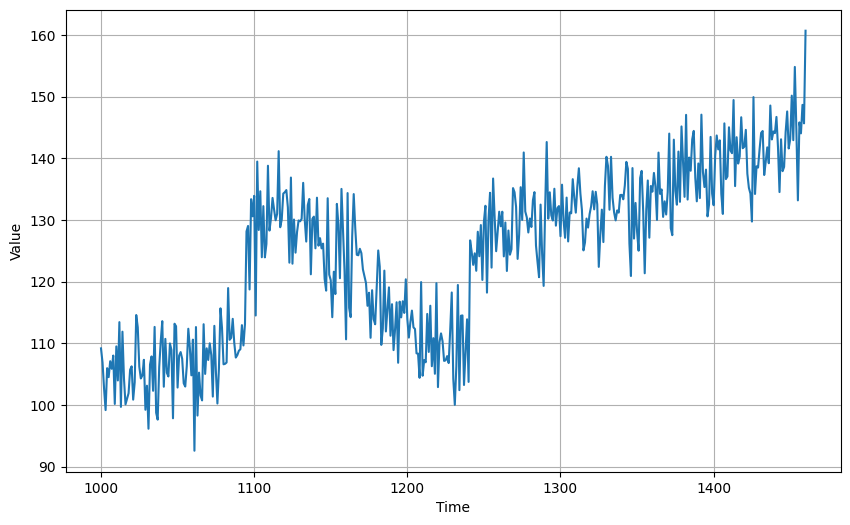

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1 ))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

합성곱 신경망과 순환 신경망을 사용하여 시퀀스 데이터를 예측하는 능력을 더욱 향상시키는 기법 학습.

1. 시퀀스 데이터를 위한 합성곱

신경망은 훈련을 통하여 픽셀을 레이블에 매핑할 때 효과적인 필터값을 학습한다. 이 과정을 거쳐 이미지에서 특징을 추출할 수 있다. 

시계열 데이터에도 적용할 수 있는데, 합성곱을 1차원에서 수행한다는 점이 다르다!

예) 아래와 같은 숫자 시계열이 있다고 가정.
[4, 8, 15, 16, 2,3, 42, 51, 64, 99, -1]

필터값이 [-0.5, 1, -0.5] 크기 필터로 합성곱을 한다고 했을 때,

첫번째 합성곱   
[4, 8, 15, 16, 23, 42, 51, 64, 99, -1] <= 숫자 시계열
[-0.5, 1, -0.5]                        <= 필터

(4*-0.5)+(8*1)+(15*-1.5)               <= 합성곱 연산


이와 같이 필터가 입력값 위를 지나면서 새로운 값을 만든다.

이런 방법을 사용하면 시퀀스 값 사이의 

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


tf.keras.models.Conv1D(): 여러가지 매개변수를 제공.

filters = 학습할 필터의 개수. 필터의 가중치는 랜덤하게 생성되고, 학습하면서 데이터에 맞게 조정됨.

kernel_size = 필터의 크기. [-0;5, 1, -0.5]와 같은 필터의 커널 크기는 3.

stride = 필터가 입력 위를 지나갈 때 스텝값. 일반적으로 1.

padding = 가장자리 데이터 처리 결정. 3x1 필터를 사용하면 첫번째와 마지막 값을 단 한번만 합성곱에 참여하게 된다. 시퀀스 데이터의 경우, causal을 사용. causal: 현재와 과거의 타임스텝만 이용. 3x1 필터의 경우, 현재 타임스텝과 이전 두개의 타임스텝의 값을 사용. 즉, 필터가 왼쪽으로 두 타임스텝 이동하여 시작. 따라서 출력 시퀀스의 길이는 입력 시퀀스의 길이와 동일!

activation = 활성화 함수. relu: 층의 출력값 중 음수를 0으로 만든다.

input_shape = 신경망에 전달할 데이터의 크기. 입력틍이므로 반드시 지정해야 한다. 

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
82/82 [==============================] - 2s 9ms/step - loss: 145.7215
Epoch 2/100
82/82 [==============================] - 1s 7ms/step - loss: 77.4965
Epoch 3/100
82/82 [==============================] - 0s 5ms/step - loss: 73.9704
Epoch 4/100
82/82 [==============================] - 0s 5ms/step - loss: 72.7308
Epoch 5/100
82/82 [==============================] - 0s 5ms/step - loss: 74.7145
Epoch 6/100
82/82 [==============================] - 0s 5ms/step - loss: 68.8186
Epoch 7/100
82/82 [==============================] - 0s 5ms/step - loss: 71.6112
Epoch 8/100
82/82 [==============================] - 0s 5ms/step - loss: 69.4794
Epoch 9/100
82/82 [==============================] - 1s 7ms/step - loss: 71.3499
Epoch 10/100
82/82 [==============================] - 0s 5ms/step - loss: 68.8658
Epoch 11/100
82/82 [==============================] - 0s 5ms/step - loss: 71.6143
Epoch 12/100
82/82 [==============================] - 0s 5ms/step - loss: 69.2533
Epoch 13/100
82/82 [====

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

모델을 사용하여 시계열을 예측하려면, Conv1D 층을 위하여 새로운 축을 추가한 시계열을 전달해야 한다.

In [25]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
# 분할 위치를 기준으로 검증 세트에 대한 예측을 별도로 분리.
results = forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 6ms/step


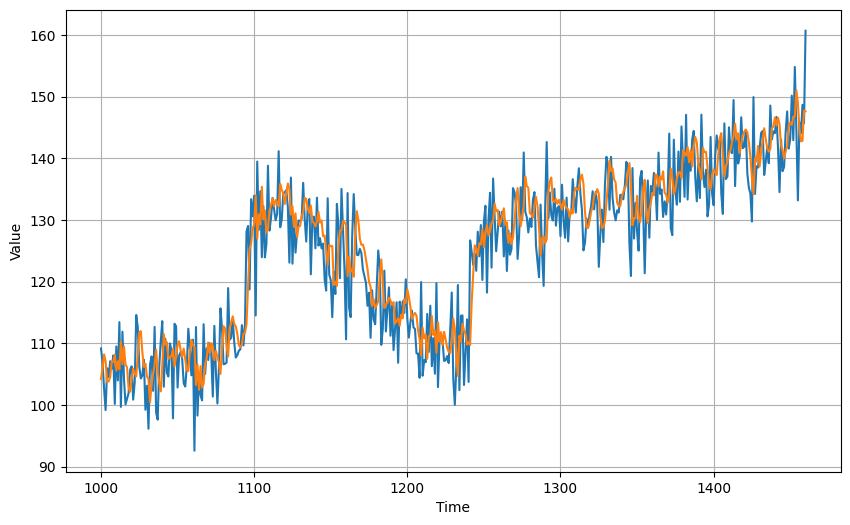

In [10]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7645802

MAE의 값이 이전보다 조금 더 나쁜 결과일 경우,   
=> 합성곱 층을 적절히 튜닝하지 않았거나,   
=> 합성곱이 도움이 되지 않기 때문일 수도 있다.    
=> 따라서 주어진 데이터를 실험해봐야 한다.   

사용한 데이터는 잡음을 가지고 있기 때문에 실행할 때마다 값이 달라짐.

### Conv1D 하이퍼파라미터 튜닝

In [6]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 17.4 MB/s eta 0:00:00


In [7]:
from keras_tuner.tuners import RandomSearch

다른 매개변수는 고정하고,   
  필터 개수: 128부터 시작, 64개씩 늘려가며 256까지   
  커널 크기: 3부터 시작, 3개씩 늘려가며 9까지   
  스트라이드 크기: 1부터 시작, 3까지   
를 테스트

In [ ]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                     kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                     strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                     padding='causal', activation='relu', input_shape=[None, 1]))

    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
    model.compile(loss="mse", optimizer=sgd)
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, 
                     executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 12 Complete [00h 02m 40s]
loss: 65.51058705647786

Best loss So Far: 63.09221394856771
Total elapsed time: 00h 22m 04s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
256               |192               |units
3                 |9                 |kernels
3                 |1                 |strides

Epoch 1/100
82/82 - 1s - loss: 228.4184 - 1s/epoch - 15ms/step
Epoch 2/100
82/82 - 0s - loss: 76.8099 - 428ms/epoch - 5ms/step
Epoch 3/100
82/82 - 0s - loss: 75.0971 - 384ms/epoch - 5ms/step
Epoch 4/100
82/82 - 0s - loss: 73.7197 - 394ms/epoch - 5ms/step
Epoch 5/100
82/82 - 0s - loss: 76.7021 - 376ms/epoch - 5ms/step
Epoch 6/100
82/82 - 0s - loss: 74.2698 - 379ms/epoch - 5ms/step
Epoch 7/100
82/82 - 0s - loss: 72.8047 - 386ms/epoch - 5ms/step
Epoch 8/100
82/82 - 0s - loss: 75.6250 - 362ms/epoch - 4ms/step
Epoch 9/100
82/82 - 0s - loss: 74.5705 - 368ms/epoch - 4ms/step
Epoch 10/100
82/82 - 0s - loss: 74.8267 - 362ms/epoch - 4ms/step
Epoch 11/100
82/8

In [18]:
tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 016 summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 59.77613957722982

Trial 007 summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 59.801509857177734

Trial 006 summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 59.836629231770836

Trial 009 summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 60.21245829264323

Trial 023 summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
Score: 60.232625325520836

Trial 001 summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 60.407126108805336

Trial 003 summary
Hyperparameters:
units: 128
kernels: 3
strides: 1
Score: 61.42434819539388

Trial 026 summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 61.452353159586586

Trial 018 summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.540304819742836

Trial 008 summary
Hyperparameters:
units:

In [19]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 1s 7ms/step


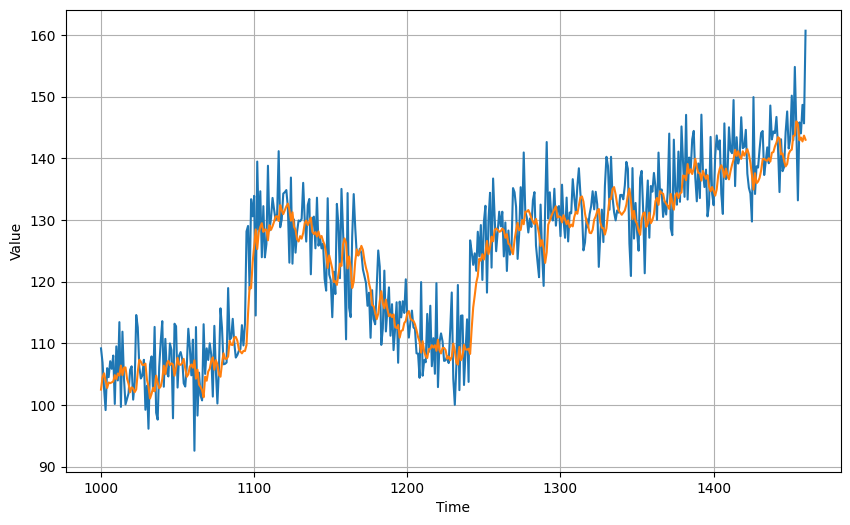

In [20]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.555304

조합의 개수가 많기 때문에 시간이 많이 소요됨.   
filters를 더 작은 값에서 시작해보는 등 다른 시도를 해볼 수 있다

=> 초기 모델 설정과 비교했을 때, 필터 크기에 큰 변화.  
=> 이는 데이터가 큰 결과   
=> 필터가 3일 때는 바로 이웃한 데이터에만 영향   
=> 필터 크기가 9라면 더 멀리 떨어진 데이터에도 필터 적용 결과에 영향   
   
즉, 하이퍼파라미터 탐색으로 얻은 필터 개수와 커널 크기가 탐색 범위의 경계에 해당하기 때문에 범위를 더 확장하여 시도해 볼 필요가 있다. 

## NASA 날씨 데이터 사용하기

### 파이썬으로 GISS 데이터 읽기

첫번째 단계: 사용자 정의함수 선언: get_station_data()
  1. 지정한 경로에서 파일을 열고, 전체 데이터를 한 줄로 읽는다
  2. 줄바꾸는 문자(\n)로 행을 구분
  3. 첫번째 줄은 건너뛰고, 각 줄을 순회하면서
  4. 콤마(,)로 구분하여 리스트(linedata)에 추가
    => 이 리스트의 1번째부터 13번째까지의 값을 1월 ~ 12월까지의 데이터.
    => 문자열로 저장되어 있으므로, 실수로 변환하여 다른 리스트(temperatures)에 추가
  5. 리스트(temperatures)를 넘파이 배열로 변환(series)
  6. 리스트(temperatures)의 길이를 이용하여 series와 동일한 크기의 넘파이 배열(time)을 저장
  7. 두 개의 넘파이 배열(series, time)을 리턴.

- 넘파이 배열(time)   
np.arange()로 만들었기 때문에,   
=> 첫번째 원소가 0, 두번째 원소가 1

따라서 사용자 정의 함수(get_station_data())는    
=> 0에서 데이터 포인트 개수 -1까지 스텝을 나타내는 time과    
=> 타임스텝 데이터 series를 반환


두번째 단계: 시계열 데이터를 정규화


세번째 단계: 훈련세트와 검증세트로 분할. 분할 위치는 데이터 크기에 따라 선택   
(840개이므로 792에서 분할: 검증을 위해 4년치 데이터를 보관)

네번째 단계: 윈도 데이터셋 (최종 데이터가 넘파이 배열)

In [1]:
!wget https://storage.googleapis.com/learning-datasets/station.csv

--2023-03-30 02:13:14--  https://storage.googleapis.com/learning-datasets/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘station.csv’

station.csv         100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-03-30 02:13:14 (63.2 MB/s) - ‘station.csv’ saved [6979/6979]



In [2]:
def get_station_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))
    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
# 두번째 단계: 시계열 데이터를 정규화

time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [9]:
# 세번째 단계: 훈련 세트와 검증 세트로 분할

split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

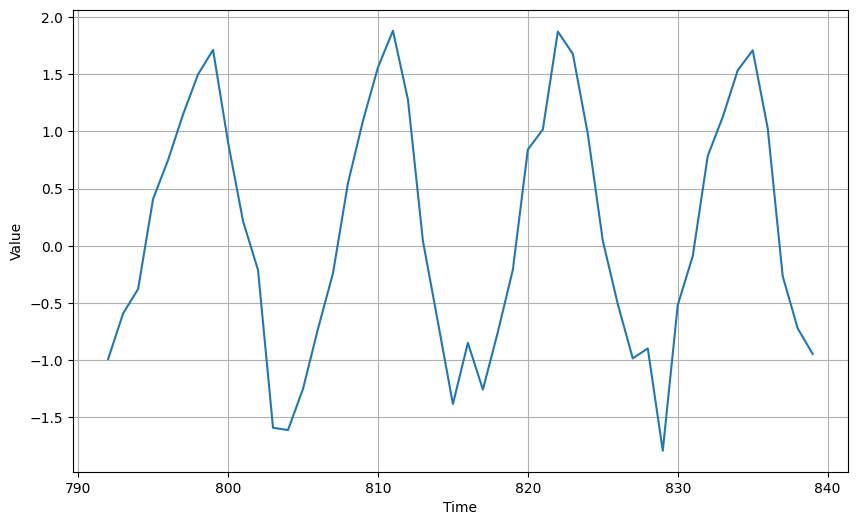

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [17]:
# 네번째 단계: 윈도 데이터셋(최종 데이터가 넘파이 배열)

window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

## RNN으로 시퀀스 모델링하기

In [18]:
# 다섯번째 단계: RNN 시퀀스 모델

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, 
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1,
                    validation_data=valid_dataset)

Epoch 1/100
82/82 [==============================] - 5s 46ms/step - loss: 59.3580 - mae: 59.8578 - val_loss: 124.5117 - val_mae: 125.0117
Epoch 2/100
82/82 [==============================] - 6s 75ms/step - loss: 58.7099 - mae: 59.2099 - val_loss: 123.8617 - val_mae: 124.3617
Epoch 3/100
82/82 [==============================] - 4s 44ms/step - loss: 58.1546 - mae: 58.6546 - val_loss: 123.4111 - val_mae: 123.9111
Epoch 4/100
82/82 [==============================] - 5s 61ms/step - loss: 57.6623 - mae: 58.1623 - val_loss: 122.9803 - val_mae: 123.4803
Epoch 5/100
82/82 [==============================] - 4s 47ms/step - loss: 57.2467 - mae: 57.7467 - val_loss: 122.6685 - val_mae: 123.1685
Epoch 6/100
82/82 [==============================] - 4s 49ms/step - loss: 56.9175 - mae: 57.4175 - val_loss: 122.4215 - val_mae: 122.9215
Epoch 7/100
82/82 [==============================] - 5s 63ms/step - loss: 56.6318 - mae: 57.1318 - val_loss: 122.1943 - val_mae: 122.6943
Epoch 8/100
82/82 [===============

In [20]:
# 여섯번째 단계: RNN 시퀀스 모델 예측

# 예측 데이터 반환 함수 정의
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

15/15 [==============================] - 0s 9ms/step


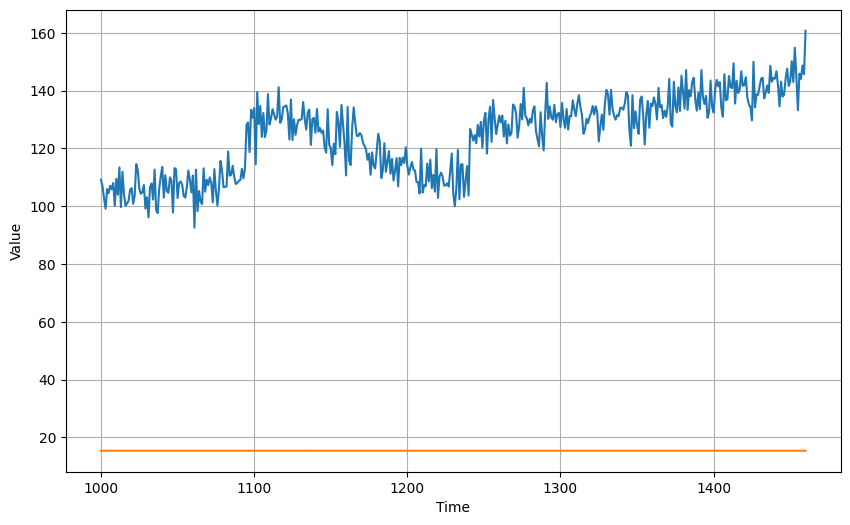

In [22]:
# 일곱전째 단계: 실제 데이터와 예측 데이터 비교

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [36]:
# 최종 단계: 손실값 확인

tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.31968334

### 대용량 데이터셋 사용하기

첫번째 단계: 사용자 정의 함수: get_tdaily_data()
  1. 데이터 파일 읽기
  2. 헤더를 제외하고,
  3. 공백을 삭제: split()
  4. 온도를 리스트에 추가(temperatures)
  5. 두개의 넘파이 배열(series, time)을 만들어 리턴

두번째 단계: 훈련 세트와 검증 세트로 분할(분할 위치는 데이터 크기에 따라 선택)

In [27]:
!wget https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

--2023-03-30 02:44:48--  https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728976 (1.6M) [text/plain]
Saving to: ‘tdaily_cet.dat.txt’

tdaily_cet.dat.txt  100%[===================>]   1.65M  2.37MB/s    in 0.7s    

2023-03-30 02:44:50 (2.37 MB/s) - ‘tdaily_cet.dat.txt’ saved [1728976/1728976]



In [28]:
def get_tdaily_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [ ]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

In [ ]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## Dropout 사용하기

In [ ]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [ ]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

In [ ]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## 양방향 RNN 사용하기

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

윈도우 크기 늘려 보기

In [ ]:
window_size = 40
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()